In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import lightgbm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score


In [2]:
# set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
vote_df = pd.read_csv("C:\\Users\\eunseo\\Desktop\\Git\\AI-project\\data\\train.csv", encoding="utf-8")
print("dataset shape: ", vote_df.shape)

dataset shape:  (36425, 78)


In [4]:
# 예측한 값으로 성능을 평가하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1
    roc_auc = roc_auc_score(y_test, pred_proba) # ROC-AUC
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 데이터 전처리

In [5]:
# 인덱스 제거
vote_df.drop("index", axis=1, inplace=True)

In [6]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['education', 'engnat', 'hand', 'urban']

# tp 추가
for i in range(1, 11):
    s = 'tp' + chr(48+(i//10)) + chr(48+(i%10))
    zero_features.append(s)
    
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균 값으로 대체
vote_df[zero_features] = vote_df[zero_features].replace(0, vote_df[zero_features].mean())

### 이상값 처리

In [7]:
Q_E = []
#Q_E 시간
for i in range(97, 117):
    a = 'Q' + chr(i) + 'E'
    Q_E.append(a)

In [8]:
# 시간 데이터 전처리 - 정확도 0.85 -> 0.94로 증가함 하지만 StandardScaler로 전처리는 의미가 없을 걸로 보임...
def get_categoty_time(Q_time):
    cat = 0
    if Q_time <= 1000 : cat = 1
    elif Q_time <= 2000 : cat = 2
    elif Q_time <= 3000 : cat = 3
    elif Q_time <= 4000 : cat = 4
    elif Q_time <= 5000 : cat = 5
    elif Q_time <= 6000 : cat = 6
    elif Q_time <= 7000 : cat = 7
    elif Q_time <= 8000 : cat = 8
    elif Q_time <= 9000 : cat = 9
    elif Q_time <=10000 : cat = 10
    elif Q_time <=15000 : cat = 11
    elif Q_time <=20000 : cat = 12
    else : Q_time = 13

    return cat


for Q_time in Q_E:
    vote_df[Q_time] = vote_df[Q_time].apply(lambda x : get_categoty_time(x))


In [9]:
#시간에 대해 이상치 데이터 인덱스 확인 및 제거
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['voted']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index    
    return outlier_index


for feature in Q_E:
    outlier_index = get_outlier(df=vote_df, column=feature, weight=1.5)
    print('이상치 데이터 인덱스 :', outlier_index)
    vote_df.drop(outlier_index, axis=0, inplace=True)

이상치 데이터 인덱스 : Int64Index([    6,    21,    22,    27,    31,    33,    35,    49,    60,
               73,
            ...
            36221, 36235, 36247, 36252, 36295, 36336, 36350, 36363, 36373,
            36424],
           dtype='int64', length=3118)
이상치 데이터 인덱스 : Int64Index([   43,    90,   143,   182,   190,   194,   250,   263,   377,
              450,
            ...
            36183, 36204, 36254, 36267, 36274, 36306, 36320, 36322, 36364,
            36387],
           dtype='int64', length=1001)
이상치 데이터 인덱스 : Int64Index([   96,   101,   131,   270,   273,   346,   409,   424,   442,
              578,
            ...
            35872, 36125, 36155, 36201, 36237, 36290, 36304, 36325, 36358,
            36365],
           dtype='int64', length=406)
이상치 데이터 인덱스 : Int64Index([    9,    66,   258,   266,   274,   400,   422,   650,   743,
              750,
            ...
            35507, 35563, 35628, 35759, 35822, 35916, 35927, 36224, 36374,
            36394],
        

### 데이터 변환

In [10]:
# 레이블 인코딩
encoder = LabelEncoder()
encoder.fit(vote_df['age_group'])
labels = encoder.transform(vote_df['age_group'])
vote_df['age_group'] = labels

In [11]:
def get_categoty_age(age_num):
    num = age_num;
    if age_num == 0: num =7

    return num
vote_df["age_group"] = vote_df["age_group"].apply(lambda x : get_categoty_age(x))
# x_test["age_group"] = x_test["age_group"].apply(lambda x : get_categoty_age(x))

In [12]:
#원핫인코딩 진행
def dummy_data(data, columns) :
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

dummy_columns = ['engnat', 'gender','hand', 'married', 'race', 'religion', 'urban']
vote_df = dummy_data(vote_df, dummy_columns)

# 모델 학습

In [13]:
# X_features, y_labels 설정
y_labels = vote_df.loc[:,'voted']
X_features = vote_df.drop('voted', axis=1)
print("피처 데이터 shape:{0}".format(X_features.shape))

피처 데이터 shape:(21526, 105)


In [14]:
# Standard Scaler 적용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
vote_scaled = scaler.fit_transform(X_features)

X_features = pd.DataFrame(data=vote_scaled, columns=X_features.columns.values.tolist())

In [15]:
# train and test data split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)
train_cnt = y_train.count()
test_cnt = y_test.count()
print("학습 세트 Shape:{0}, 테스트 세트 Shape:{1}".format(X_train.shape, X_test.shape))

print(" 학습 세트 레이블 값 분포 비율")
print(y_train.value_counts()/train_cnt)
print("\n 테스트 세트 레이블 값 분포 비율")
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(17220, 105), 테스트 세트 Shape:(4306, 105)
 학습 세트 레이블 값 분포 비율
0    0.923868
1    0.076132
Name: voted, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.931026
1    0.068974
Name: voted, dtype: float64


### SMOTE

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print()
print('SMOTE 적용 후 레이블 값 분포:')
print(y_train_over.value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (17220, 105) (17220,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (31818, 105) (31818,)

SMOTE 적용 후 레이블 값 분포:
1    15909
0    15909
Name: voted, dtype: int64


### 하이퍼 파라미터 튜닝

In [18]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [19]:
# max_depth 와 min_child_weight 튜닝
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=400, 
                                                  max_depth=3, 
                                                  min_child_weight=3, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=-1, 
                                                  scale_pos_weight=1,
                                                  random_state=156), 
                        param_grid = param_test1, scoring='f1',n_jobs=-1,iid=False, cv=5, verbose=10)
gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# Gamma 튜닝
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=400, 
                                                  max_depth=3,
                                                  min_child_weight=3, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1, 
                                                  random_state=156), 
                        param_grid = param_test2, scoring='f1', n_jobs=-1, iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
# subsample 과 colsample_bytree 튜닝
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=400, 
                                                  max_depth=3,
                                                  min_child_weight=3, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1, 
                                                  random_state=156), 
                        param_grid = param_test3, scoring='f1', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch3.fit(X_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
# subsample 추가 튜닝
param_test4 = {
 'subsample':[i/100.0 for i in range(40,80)],
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=400, 
                                                  max_depth=3,
                                                  min_child_weight=3, 
                                                  gamma=0, 
                                                  reg_alpha=1e-05,
                                                  subsample=0.8, 
                                                  colsample_bytree=0.6,
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1, 
                                                  random_state=156), 
                        param_grid = param_test4, scoring='f1', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch4.fit(X_train, y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
# Regularization Parameter 튜닝
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=400, 
                                                  max_depth=3,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.6,
                                                  objective= 'binary:logistic', 
                                                  thread=-1, 
                                                  scale_pos_weight=1,
                                                  random_state=156), 
                        param_grid = param_test5, scoring='f1', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch5.fit(X_train, y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

### XGB

In [15]:
### Test 1 ###

evals = [(X_test, y_test)]
xgb_model = XGBClassifier(
    learning_rate =0.1, # 0.01
    n_estimators=1000,
    max_depth=3,
    min_child_weight=5,
    gamma=0,
    reg_alpha=1e-05,
    subsample=0.77,
    colsample_bytree=0.6,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    random_state=156
)

# xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", min_child_weight=3, colsample_bytree=0.5, random_state=156)
xgb_model.fit(X_train_over, y_train_over, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
w_preds = xgb_model.predict(X_test)
w_pred_proba = xgb_model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_pred_proba)

[0]	validation_0-logloss:0.646928
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.608924
[2]	validation_0-logloss:0.577464
[3]	validation_0-logloss:0.550873
[4]	validation_0-logloss:0.528018
[5]	validation_0-logloss:0.508882
[6]	validation_0-logloss:0.491397
[7]	validation_0-logloss:0.476649
[8]	validation_0-logloss:0.463511
[9]	validation_0-logloss:0.452252
[10]	validation_0-logloss:0.441953
[11]	validation_0-logloss:0.432716
[12]	validation_0-logloss:0.424956
[13]	validation_0-logloss:0.417415
[14]	validation_0-logloss:0.410638
[15]	validation_0-logloss:0.40478
[16]	validation_0-logloss:0.399238
[17]	validation_0-logloss:0.394161
[18]	validation_0-logloss:0.389427
[19]	validation_0-logloss:0.385197
[20]	validation_0-logloss:0.381095
[21]	validation_0-logloss:0.377624
[22]	validation_0-logloss:0.374119
[23]	validation_0-logloss:0.37072
[24]	validation_0-logloss:0.367619
[25]	validation_0-logloss:0.364492
[26]	validation_0-logloss:0.36166

[230]	validation_0-logloss:0.256304
[231]	validation_0-logloss:0.256235
[232]	validation_0-logloss:0.256223
[233]	validation_0-logloss:0.256165
[234]	validation_0-logloss:0.256065
[235]	validation_0-logloss:0.256034
[236]	validation_0-logloss:0.256008
[237]	validation_0-logloss:0.25594
[238]	validation_0-logloss:0.255915
[239]	validation_0-logloss:0.255856
[240]	validation_0-logloss:0.255783
[241]	validation_0-logloss:0.255722
[242]	validation_0-logloss:0.255712
[243]	validation_0-logloss:0.255649
[244]	validation_0-logloss:0.255586
[245]	validation_0-logloss:0.255551
[246]	validation_0-logloss:0.255557
[247]	validation_0-logloss:0.255521
[248]	validation_0-logloss:0.255506
[249]	validation_0-logloss:0.255444
[250]	validation_0-logloss:0.255274
[251]	validation_0-logloss:0.255194
[252]	validation_0-logloss:0.255193
[253]	validation_0-logloss:0.255127
[254]	validation_0-logloss:0.25506
[255]	validation_0-logloss:0.254988
[256]	validation_0-logloss:0.254955
[257]	validation_0-logloss:0.2

In [33]:
### Test 2 ###
from xgboost import XGBClassifier

evals = [(X_test, y_test)]
# xgb_model = XGBClassifier(
#     learning_rate =0.1, # 0.01
#     n_estimators=1000,
#     max_depth=3,
#     min_child_weight=5,
#     gamma=0,
#     reg_alpha=1e-05,
#     subsample=0.77,
#     colsample_bytree=0.6,
#     objective= 'binary:logistic',
#     nthread=-1,
#     scale_pos_weight=1,
#     random_state=156
# )

xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model.fit(X_train_over, y_train_over, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
w_preds = xgb_model.predict(X_test)
w_pred_proba = xgb_model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_pred_proba)

[0]	validation_0-logloss:0.632057
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.58331
[2]	validation_0-logloss:0.543257
[3]	validation_0-logloss:0.508664
[4]	validation_0-logloss:0.47909
[5]	validation_0-logloss:0.452565
[6]	validation_0-logloss:0.429388
[7]	validation_0-logloss:0.409097
[8]	validation_0-logloss:0.391081
[9]	validation_0-logloss:0.375003
[10]	validation_0-logloss:0.361041
[11]	validation_0-logloss:0.347438
[12]	validation_0-logloss:0.334948
[13]	validation_0-logloss:0.323935
[14]	validation_0-logloss:0.314044
[15]	validation_0-logloss:0.304814
[16]	validation_0-logloss:0.296733
[17]	validation_0-logloss:0.289273
[18]	validation_0-logloss:0.281351
[19]	validation_0-logloss:0.27326
[20]	validation_0-logloss:0.26684
[21]	validation_0-logloss:0.261632
[22]	validation_0-logloss:0.25571
[23]	validation_0-logloss:0.249915
[24]	validation_0-logloss:0.245186
[25]	validation_0-logloss:0.241121
[26]	validation_0-logloss:0.236031
[

[230]	validation_0-logloss:0.105401
[231]	validation_0-logloss:0.10537
[232]	validation_0-logloss:0.105318
[233]	validation_0-logloss:0.105317
[234]	validation_0-logloss:0.105317
[235]	validation_0-logloss:0.105252
[236]	validation_0-logloss:0.105185
[237]	validation_0-logloss:0.105142
[238]	validation_0-logloss:0.105091
[239]	validation_0-logloss:0.105058
[240]	validation_0-logloss:0.105011
[241]	validation_0-logloss:0.104958
[242]	validation_0-logloss:0.104893
[243]	validation_0-logloss:0.104892
[244]	validation_0-logloss:0.104747
[245]	validation_0-logloss:0.104672
[246]	validation_0-logloss:0.104624
[247]	validation_0-logloss:0.104519
[248]	validation_0-logloss:0.104481
[249]	validation_0-logloss:0.1044
[250]	validation_0-logloss:0.104358
[251]	validation_0-logloss:0.104297
[252]	validation_0-logloss:0.104272
[253]	validation_0-logloss:0.1042
[254]	validation_0-logloss:0.10405
[255]	validation_0-logloss:0.104
[256]	validation_0-logloss:0.103954
[257]	validation_0-logloss:0.103949
[

### feature selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

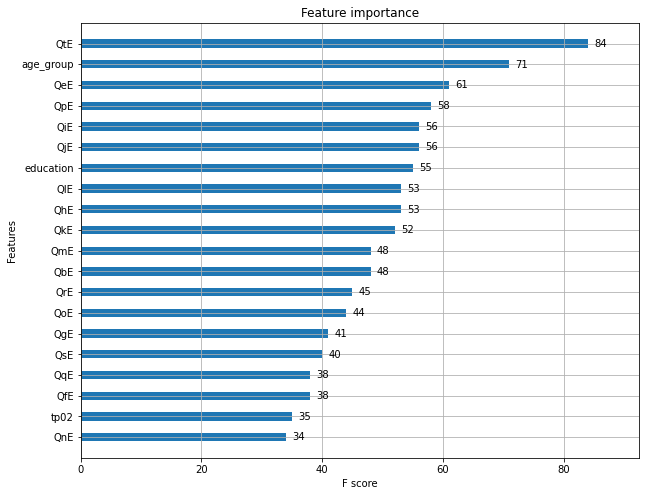

In [36]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)